In [0]:
# Importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from scipy.stats import norm
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from keras import objectives
import numpy as np
from keras.datasets import fashion_mnist
import os

In [0]:
# Setting up the hyper-parameter

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [0]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(batch_size,latent_dim), mean = 0.)
  return z_mean + K.exp(z_log_var/2) * epsilon

In [0]:
# Encoder Network

x = tf.keras.layers.Input(shape=(original_dim,), name="input")                          
h = tf.keras.layers.Dense(intermediate_dim, activation='relu', name="encoding")(x)      
z_mean = tf.keras.layers.Dense(latent_dim, name="mean")(h)                              
z_log_var = tf.keras.layers.Dense(latent_dim, name="log-variance")(h)                   
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])   
encoder = tf.keras.Model(x, [z_mean, z_log_var, z], name="encoder")          

In [22]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

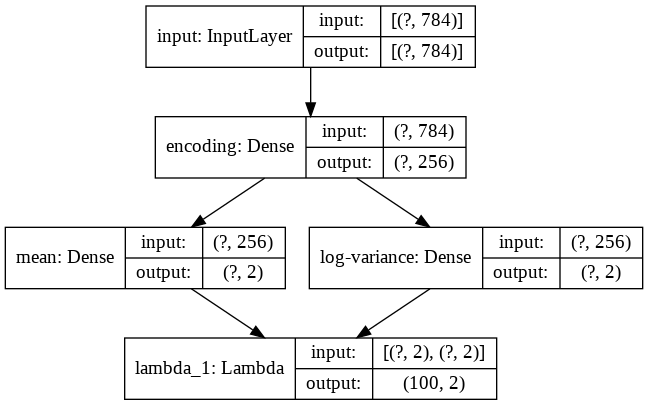

In [23]:
tf.keras.utils.plot_model(model= encoder , show_layer_names= True , show_shapes= True)

In [0]:
input_decoder = tf.keras.layers.Input(shape=(latent_dim,), name="decoder_input")   
decoder_h = tf.keras.layers.Dense(intermediate_dim, activation='relu',name="decoder_h")(input_decoder)
x_decoded = tf.keras.layers.Dense(original_dim, activation='sigmoid',name="flat_decoded")(decoder_h)                                    
decoder = tf.keras.Model(input_decoder, x_decoded, name="decoder")


In [25]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


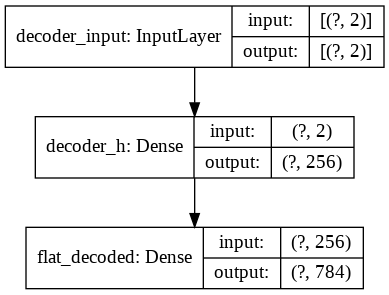

In [26]:
tf.keras.utils.plot_model(model= decoder , show_layer_names= True , show_shapes= True)

In [27]:
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (1 201988    
_________________________________________________________________
decoder (Model)              multiple                  202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [28]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor, z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
  
    # Reconstruction Loss
    xent_loss = original_dim * tf.keras.metrics.binary_crossentropy(x, x_decoded_mean)

    # Kullback-Leibler Divergence
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (1 201988    
_________________________________________________________________
decoder (Model)              multiple                  202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Dataset:

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [31]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 150us/sample - loss: 304.7727
Epoch 2/50
60000/60000 [==============================] - 9s 151us/sample - loss: 279.3459
Epoch 3/50
60000/60000 [==============================] - 10s 160us/sample - loss: 274.8409
Epoch 4/50
60000/60000 [==============================] - 10s 161us/sample - loss: 272.7702
Epoch 5/50
60000/60000 [==============================] - 10s 161us/sample - loss: 271.4450
Epoch 6/50
60000/60000 [==============================] - 10s 161us/sample - loss: 270.5055
Epoch 7/50
60000/60000 [==============================] - 10s 159us/sample - loss: 269.6178
Epoch 8/50
60000/60000 [==============================] - 10s 161us/sample - loss: 268.9343
Epoch 9/50
60000/60000 [==============================] - 10s 162us/sample - loss: 268.3264
Epoch 10/50
60000/60000 [==============================] - 10s 163us/sample - loss: 267.8151
Epoch 11/50
60000/60000 [==============================] -

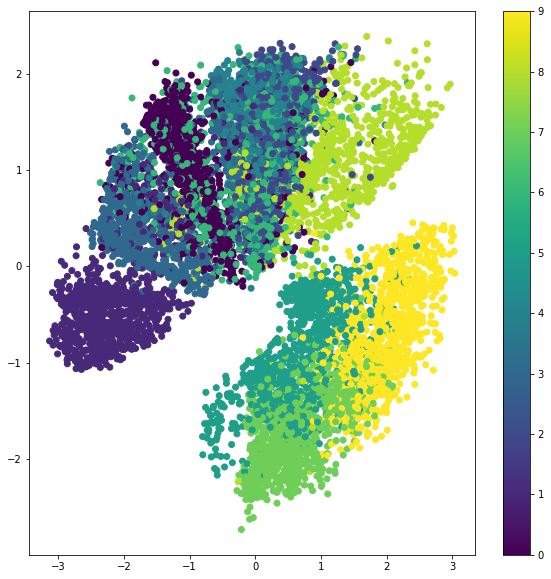

In [35]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

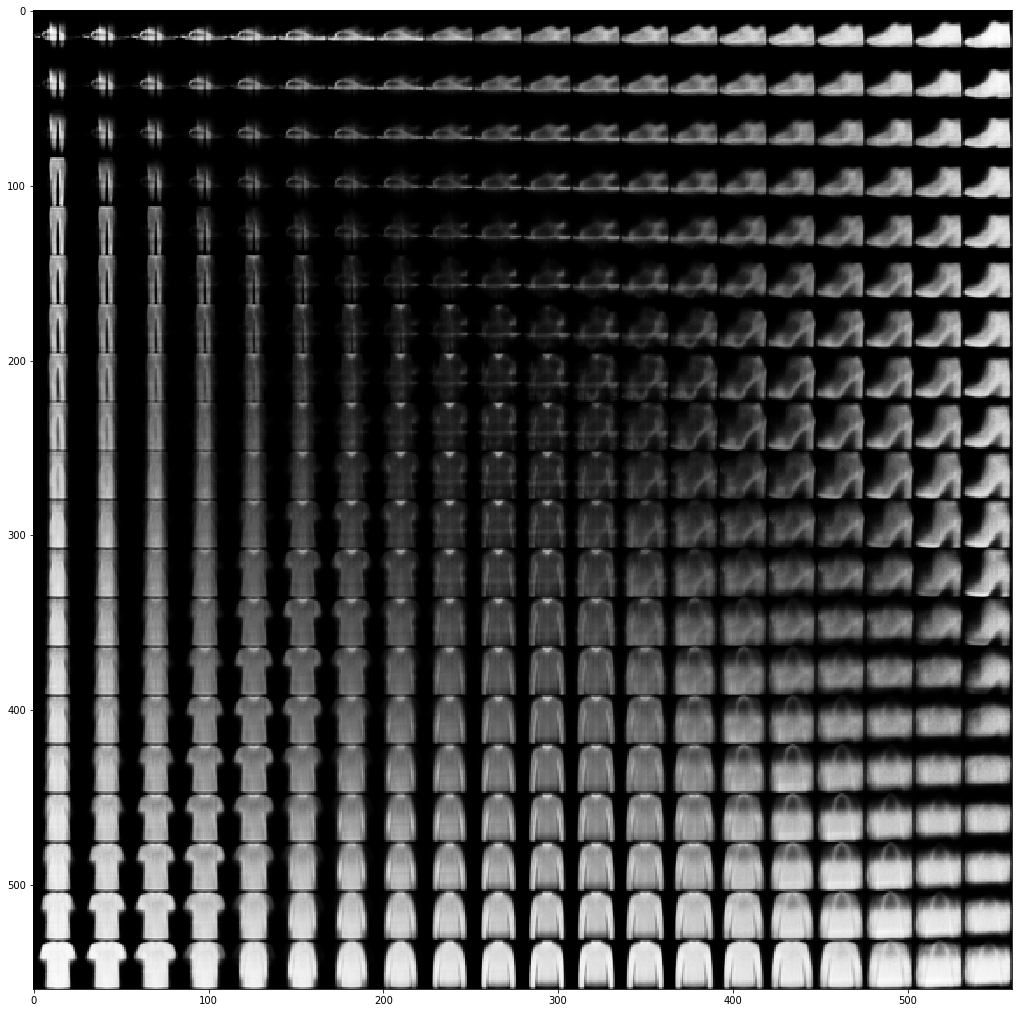

In [38]:
# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(18, 18))
plt.imshow(figure, cmap='Greys_r')
plt.show()